# Feature Selection


## Mount Google Drive

In [1]:
#mount google drive
from google.colab import drive
import glob
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading the data

In [2]:
import numpy as np
import os
import cv2
import csv
import json
import pandas as pd

In [3]:
normal_csv = '/content/gdrive/MyDrive/ICU/Output/All/V1-original/Normal.csv'
burglar_csv = '/content/gdrive/MyDrive/ICU/Output/All/V1-original/Burglar.csv'

In [4]:
normal_df = pd.read_csv(normal_csv, header=None)
burglar_df = pd.read_csv(burglar_csv, header=None)
data_df = normal_df.append(burglar_df, ignore_index=False)

##Drop the z confidence column values

In [5]:
drop = list(range(2,75,3))

In [6]:
data_df.drop(columns=data_df.columns[drop], axis=0, inplace=True)

In [8]:
#For future references 
output_csv = '/content/gdrive/MyDrive/ICU/Output/All/1st-Try/Output.csv'
data_df.to_csv (output_csv, index = False, header=False)

# Feature Scaling

In [7]:
data_array = data_df.to_numpy()

In [8]:
print(len(data_array))

70084


In [63]:
normal_array = []
burglar_array = []
normal_label = '001'
burglar_label = '001'

In [9]:
test_data = []
train_data = []

train_labels = []
test_labels = []

In [11]:
print(len(test_data))
print

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Separate training, test data and labels

In [65]:
for row in data_array:

  if(row[51] == 'Normal'):

    if(row[50][1:4] == normal_label):
      row = np.delete(row,51) #remove file name and label
      row = np.delete(row,50)
      normal_array.append(row)

    else:
      num = int(normal_label)

      if( num <= 42):
        test_labels.append(0)
        test_data.append(np.array(normal_array))

      else:
        train_labels.append(0)
        train_data.append(np.array(normal_array))

      normal_array= []
      normal_label = row[50][1:4]
      row = np.delete(row,51)
      row = np.delete(row,50)
      normal_array.append(row)
      
  else:

    if(row[50][0:3] == burglar_label):
      row = np.delete(row,51) #remove file name and label
      row = np.delete(row,50)
      burglar_array.append(row)

    else:
      num = int(burglar_label)

      if(num < 30):
        test_labels.append(1)
        test_data.append(np.array(burglar_array))

      else:
        train_labels.append(1)
        train_data.append(np.array(burglar_array))

      burglar_array = []
      burglar_label = row[50][0:3]
      row = np.delete(row,51)
      row = np.delete(row,50)
      burglar_array.append(row)

train_labels.append(0) 
train_labels.append(1)
train_data.append(np.array(normal_array))
train_data.append(np.array(burglar_array))

In [66]:
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

## Normalize the data

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [69]:
def normalize_data(data):
  for i in range(len(data)):
    data[i] = scaler.fit_transform(data[i])
  return data

In [70]:
train_data = normalize_data(train_data)
test_data = normalize_data(test_data)

## Shuffle the data

In [71]:
from sklearn.utils import shuffle

In [72]:
train_data, train_labels = shuffle(train_data,train_labels,random_state=0)

## Masking and padding sequences

In [73]:
from keras.preprocessing.sequence import pad_sequences

In [74]:
train_data = pad_sequences(train_data, maxlen=300)
test_data = pad_sequences(test_data,maxlen=300)

In [76]:
print(train_data.shape)
print(test_data.shape)
print(train_data.shape[1])
print(len(test_labels))
print(len(train_labels))

(313, 300, 50)
(71, 300, 50)
300
71
313


# Create Model

In [120]:
import numpy as np
from keras.models import Sequential
from keras.layers import Activation
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [121]:
batch_size = 26 # iterations = 12
epochs = 30
n_classes = 2
n_features = 50

In [103]:
def create_model():
  model = Sequential()
  ## lstm
  model.add(LSTM(units = n_features, 
                 return_sequences = True,
                 input_shape=(train_data.shape[1], n_features)))
  model.add(Dropout(0.2))

  # Adding a second LSTM layer and Dropout layer
  model.add(LSTM(units = n_features, return_sequences = True))
  model.add(Dropout(0.2))

  # Adding a third LSTM layer and Dropout layer
  model.add(LSTM(units = n_features))
  model.add(Dropout(0.2))
  ##Classification dense layer
  model.add(Dense(1,activation='sigmoid'))
  model.compile(
      optimizer=Adam(lr=0.0025),
      loss='binary_crossentropy',
      metrics=['acc'])
  return model

In [122]:
model = create_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 300, 50)           20200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 300, 50)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 300, 50)           20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 300, 50)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

# Train Model

In [123]:
history = model.fit(train_data, train_labels, batch_size = batch_size, validation_split=0.2, epochs = epochs, verbose=2)

Epoch 1/30
10/10 - 1s - loss: 0.6711 - acc: 0.6120 - val_loss: 0.6865 - val_acc: 0.5714
Epoch 2/30
10/10 - 0s - loss: 0.6528 - acc: 0.6320 - val_loss: 0.6596 - val_acc: 0.6508
Epoch 3/30
10/10 - 0s - loss: 0.5971 - acc: 0.7160 - val_loss: 0.6478 - val_acc: 0.6349
Epoch 4/30
10/10 - 0s - loss: 0.5330 - acc: 0.6920 - val_loss: 0.6068 - val_acc: 0.6508
Epoch 5/30
10/10 - 0s - loss: 0.4993 - acc: 0.7400 - val_loss: 0.6399 - val_acc: 0.6508
Epoch 6/30
10/10 - 0s - loss: 0.4684 - acc: 0.7760 - val_loss: 0.7336 - val_acc: 0.6349
Epoch 7/30
10/10 - 0s - loss: 0.4673 - acc: 0.7440 - val_loss: 0.6166 - val_acc: 0.6825
Epoch 8/30
10/10 - 0s - loss: 0.4098 - acc: 0.7960 - val_loss: 0.7162 - val_acc: 0.6825
Epoch 9/30
10/10 - 0s - loss: 0.3641 - acc: 0.8080 - val_loss: 0.7946 - val_acc: 0.6032
Epoch 10/30
10/10 - 0s - loss: 0.3611 - acc: 0.8080 - val_loss: 0.7672 - val_acc: 0.6032
Epoch 11/30
10/10 - 0s - loss: 0.3309 - acc: 0.8320 - val_loss: 0.8267 - val_acc: 0.6508
Epoch 12/30
10/10 - 0s - loss:

# Model Evaluation

In [86]:
import matplotlib.pyplot as plt

In [117]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


### Training Accuracy History

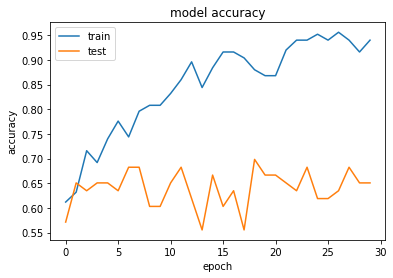

In [124]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Training Loss History

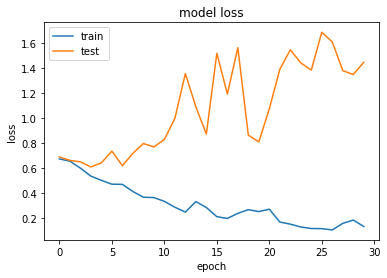

In [125]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()